# Downloading and Spliting Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:13<00:00, 80.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
output_dir = 'split_dataset'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create directories for split dataset
def create_dir_structure():
    for split_dir in [train_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)

# Split dataset
def split_dataset():
    create_dir_structure()

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Get all image file paths in the current class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split data into train (70%), test (30%)
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

        # Move images to respective directories
        for image in train_images:
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in test_images:
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

# Run the script
if __name__ == '__main__':
    split_dataset()
    print("Dataset successfully split into train, and test sets!")


Dataset successfully split into train, and test sets!


In [ ]:
import glob

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *
set_seed(42)


# train images
train_path="split_dataset/train"
train_files = get_image_files(train_path)

# test images
test_path = "split_dataset/test"
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv("/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train.csv")
print(train_df.shape)
train_df.label.value_counts()

(10407, 4)


,count
label,
normal,1764
blast,1738
hispa,1594
dead_heart,1442
tungro,1088
brown_spot,965
downy_mildew,620
bacterial_leaf_blight,479
bacterial_leaf_streak,380


Train and Val Dataloader

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [ ]:
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


In [ ]:
learn.fine_tune(50, 0.005)
# learn.fine_tune(2, 0.005)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.980224,1.201716,0.377060,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.996735,0.588670,0.185440,01:05
1,0.635342,0.414368,0.120192,01:02
2,0.425012,0.313579,0.095467,01:03
3,0.307102,0.337499,0.105082,01:02
4,0.239772,0.270573,0.078984,01:02
5,0.195085,0.304243,0.080357,01:03
6,0.230077,0.370071,0.087912,01:02
7,0.223296,0.334487,0.090659,01:02
8,0.219530,0.319249,0.083104,01:02
9,0.222937,0.360202,0.096841,01:02


In [ ]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0364)

In [ ]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0391)

# Testing model

In [ ]:
# test images
test_path = "split_dataset/test/"
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes,
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.99254   0.92361   0.95683       144
   bacterial_leaf_streak    0.97414   0.99123   0.98261       114
bacterial_panicle_blight    0.97980   0.95098   0.96517       102
                   blast    0.96183   0.96552   0.96367       522
              brown_spot    0.96918   0.97586   0.97251       290
              dead_heart    0.99080   0.99538   0.99309       433
            downy_mildew    0.93889   0.90860   0.92350       186
                   hispa    0.96488   0.97495   0.96989       479
                  normal    0.97026   0.98491   0.97753       530
                  tungro    0.97538   0.96942   0.97239       327

                accuracy                        0.97090      3127
               macro avg    0.97177   0.96405   0.96772      3127
            weighted avg    0.97092   0.97090   0.97081      3127



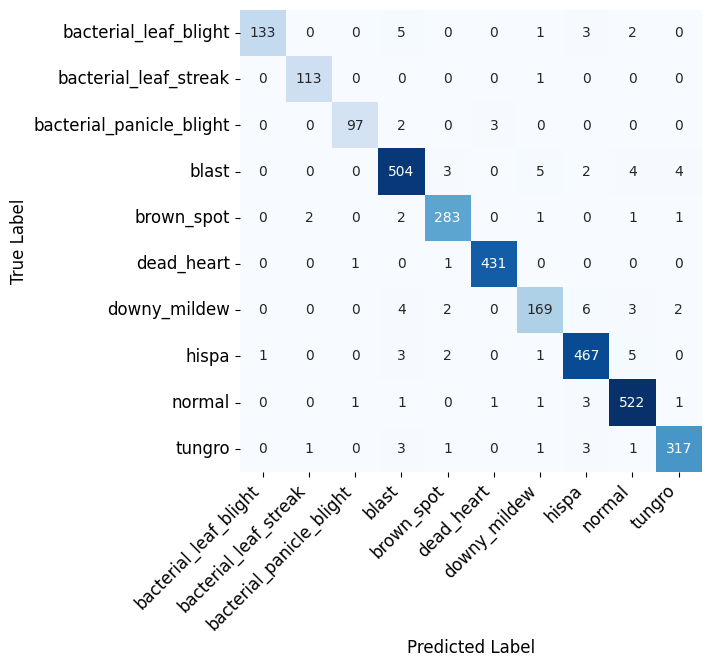

[[133   0   0   5   0   0   1   3   2   0]
 [  0 113   0   0   0   0   1   0   0   0]
 [  0   0  97   2   0   3   0   0   0   0]
 [  0   0   0 504   3   0   5   2   4   4]
 [  0   2   0   2 283   0   1   0   1   1]
 [  0   0   1   0   1 431   0   0   0   0]
 [  0   0   0   4   2   0 169   6   3   2]
 [  1   0   0   3   2   0   1 467   5   0]
 [  0   0   1   1   0   1   1   3 522   1]
 [  0   1   0   3   1   0   1   3   1 317]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")

plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

In [ ]:
temp = pd.DataFrame({"y_true":test_classes,
                      "y_pred":pred_classes})
temp.to_csv('result.csv', index=False)
temp

,y_true,y_pred
0,bacterial_leaf_blight,bacterial_leaf_blight
1,bacterial_leaf_blight,bacterial_leaf_blight
2,bacterial_leaf_blight,bacterial_leaf_blight
3,bacterial_leaf_blight,normal
4,bacterial_leaf_blight,hispa
...,...,...
3122,tungro,tungro
3123,tungro,tungro
3124,tungro,tungro
3125,tungro,tungro
